In [1]:
#print("hello world")

In [1]:

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,Activation,LeakyReLU,BatchNormalization,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
import pickle
import cv2
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer,MultiLabelBinarizer
from sklearn.model_selection import train_test_split


In [7]:
root_dir = r'C:\Users\Manush Khatri\Desktop\PHD\PlantVillage'
#C:\Users\Manush Khatri\Desktop\PHD

os.chdir(root_dir)
listdir()

['train', 'valid']

In [8]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 100

data_dir = os.path.join(root_dir,'train')

"""We use the function `convert_image_to_array` to resize an image to the size `DEFAULT_IMAGE_SIZE` we defined above."""

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [9]:
print("Load images from all classes ...")
plant_disease_folder_list = listdir(data_dir)
print(len(plant_disease_folder_list))

Load images from all classes ...
38


# Loading Training & Validation Data

In [10]:
image_list, label_list = [], []

try:
    print("Loding Image Data ...")
    for s in listdir():
        plant_disease_folder_list = listdir(s)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"Processing  {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{data_dir}/{plant_disease_folder}/")

            for image in plant_disease_image_list[:N_IMAGES]:
                image_directory = f"{data_dir}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)

    print("All the images have successfully loaded!!")  
except Exception as e:
    print(f"Error : {e}")

Loding Image Data ...
Processing  Apple___Apple_scab ...
Processing  Apple___Black_rot ...
Processing  Apple___Cedar_apple_rust ...
Processing  Apple___healthy ...
Processing  Blueberry___healthy ...
Processing  Cherry_(including_sour)___healthy ...
Processing  Cherry_(including_sour)___Powdery_mildew ...
Processing  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
Processing  Corn_(maize)___Common_rust_ ...
Processing  Corn_(maize)___healthy ...
Processing  Corn_(maize)___Northern_Leaf_Blight ...
Processing  Grape___Black_rot ...
Processing  Grape___Esca_(Black_Measles) ...
Processing  Grape___healthy ...
Processing  Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
Processing  Orange___Haunglongbing_(Citrus_greening) ...
Processing  Peach___Bacterial_spot ...
Processing  Peach___healthy ...
Processing  Pepper,_bell___Bacterial_spot ...
Processing  Pepper,_bell___healthy ...
Processing  Potato___Early_blight ...
Processing  Potato___healthy ...
Processing  Potato___Late_blight ...


In [12]:
print(len(image_list))

7600


In [11]:
# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

Total number of images: 7600


# One-Hot Encoding the labels

In [35]:
"""Examine the labels/classes in the training dataset."""classes)

<>:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
<>:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
C:\Users\Manush Khatri\AppData\Local\Temp\ipykernel_31660\3281633791.py:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  """Examine the labels/classes in the training dataset."""(classes)


NameError: name 'classes' is not defined

In [38]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print("Total number of classes: ", n_classes)

Total number of classes:  38


In [39]:
"""# Augment and Split Dataset
Using `ImageDataGenerator` to augment data by performing various operations on the training images.
"""

augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

In [40]:
"""Splitting the data into training and test sets for validation purpose."""

x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)
print('Successfully split data into TRAIN & TEST')

Successfully split data into TRAIN & TEST


In [41]:
"""# Build Model
Defining the hyperparameters of the plant disease classification model.
"""

EPOCHS = 10
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3


In [42]:
"""Creating a Sequential Model to build CNN for multi-class classification"""

model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024, name = 'my_dense'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)       

## Feature Extraction from the Dense Layer

In [43]:
layer_name = 'my_dense'
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output) 
intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0     

In [44]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define the learning rate schedule
lr_schedule = ExponentialDecay(initial_learning_rate=LR, decay_steps=len(x_train) // BATCH_SIZE, decay_rate=0.95, staircase=True)

# Initialize optimizer with the learning rate schedule
opt = Adam(learning_rate=lr_schedule)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("Training CNN...")
history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(x_test, y_test),
                    epochs=10, 
                    verbose=1)
        
scores = model.evaluate(x_test, y_test)
#print(f"Test Accuracy: {scores[1] * 100}")y: {scores[1]*100}")


Training CNN...
Epoch 1/10


190/190 [==============================] - 437s 2s/step - loss: 0.4286 - accuracy: 0.1145 - val_loss: 0.1311 - val_accuracy: 0.0454
Epoch 2/10
190/190 [==============================] - 366s 2s/step - loss: 0.1006 - accuracy: 0.3964 - val_loss: 0.1181 - val_accuracy: 0.1632
Epoch 3/10
190/190 [==============================] - 342s 2s/step - loss: 0.0753 - accuracy: 0.5487 - val_loss: 0.1185 - val_accuracy: 0.2678
Epoch 4/10
190/190 [==============================] - 346s 2s/step - loss: 0.0626 - accuracy: 0.6345 - val_loss: 0.0562 - val_accuracy: 0.6493
Epoch 5/10
190/190 [==============================] - 338s 2s/step - loss: 0.0535 - accuracy: 0.6990 - val_loss: 0.0801 - val_accuracy: 0.5401
Epoch 6/10
190/190 [==============================] - 340s 2s/step - loss: 0.0448 - accuracy: 0.7553 - val_loss: 0.0972 - val_accuracy: 0.4776
Epoch 7/10
190/190 [==============================] - 338s 2s/step - loss: 0.0385 - accuracy: 0.7919 - val_loss: 0.0521 - va

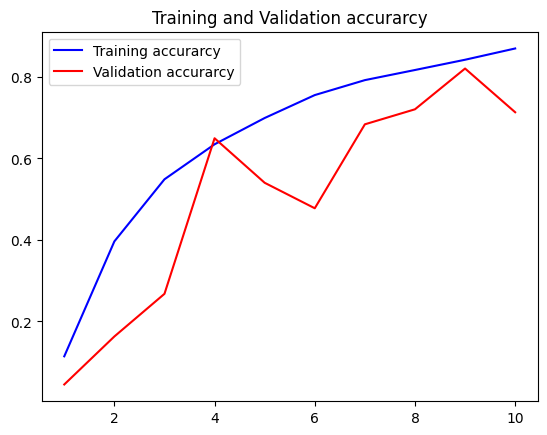

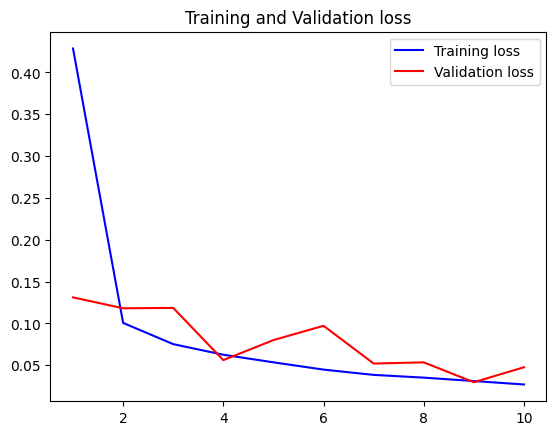

[INFO] Calculating model accuracy
48/48 [==============================] - 16s 324ms/step - loss: 0.0476 - accuracy: 0.7132
Test Accuracy: 71.31578922271729


In [45]:
"""# Evaluate Model
Comparing the accuracy and loss by plotting the graph for training and validation.
"""

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

"""Evaluating model accuracy by using the `evaluate` method"""

print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

In [22]:
#Saving the Model
# model.save('PDD_completemodel'
# model.save('PDD_completemodel.h

# intermediate_layer_model.save('PDD_IntermediateMode)
# intermediate_layer_model.save('PDD_IntermediateModel.h5')

In [46]:
x_train_predict = intermediate_layer_model.predict(x_train)
# print(x_train_predict.shape)

x_test_predict = intermediate_layer_model.predict(x_test)
print(x_test_predict.shape)

48/48 [==============================] - 16s 319ms/step
(1520, 1024)


# Support Vector Machine

Integration of CNN with Support Vector Machine.

In [47]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(x_train_predict,np.argmax(y_train,axis=1))

print('SVM Fit Complete')

SVM Fit Complete


In [48]:
svm.score(x_train_predict,np.argmax(y_train,axis=1))

0.9666118421052632

In [49]:
svm.score(x_test_predict,np.argmax(y_test,axis=1))

#Save the SVM model in pickle fil
# pickle.dump(svm,open('svms.pkl', 'wb'))

0.9519736842105263

In [50]:
Pred_labels = svm.predict(x_test_predict)
Pred_labels = pd.DataFrame(Pred_labels,index =None)
Pred_labels.head()

,0
0,31
1,9
2,28
3,13
4,4


In [51]:
model.save('PDD_completemodelstar.h5')

C:\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
print("Model Input Shape:", model.input_shape)

Model Input Shape: (None, 256, 256, 3)


In [65]:
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import numpy as np

# Load and preprocess the input image
img_path = 'C:\\Users\\Manush Khatri\\Desktop\\test\\PotatoEarlyBlight4.JPG'
img = image.load_img(img_path, target_size=(256, 256))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values if needed

# Make predictions
predictions = model.predict(img_array)

# Display or use the predictions as needed
print(predictions)

predicted_class_label = image_labels[np.argmax(predictions)]
print("Predicted Class Label:", predicted_class_label)

# Assuming predictions is the array you provided
#predicted_class_index = np.argmax(predictions)

# Get the corresponding class label
#predicted_class_label = image_labels[predicted_class_index]

# Print or use the predicted class label
#print("Predicted Class Label:", predicted_class_label)

1/1 [==============================] - 0s 53ms/step
[[1.60268771e-13 8.05421418e-09 1.26696910e-14 3.58307481e-08
  7.66223717e-15 6.54034116e-09 6.85071029e-07 1.21772370e-14
  1.54069854e-10 1.06713725e-14 2.89071949e-08 5.61563362e-16
  5.81720951e-06 6.51168719e-09 4.08580149e-11 1.41002973e-10
  8.17815477e-15 2.39766304e-18 1.39643410e-13 1.87689753e-09
  1.79689139e-17 2.86817584e-11 9.99991775e-01 1.27687771e-09
  1.22839239e-07 3.39797569e-12 7.00271004e-13 1.48278008e-18
  4.38216710e-13 3.13558818e-10 1.67128111e-13 3.32125769e-15
  1.54540128e-14 1.61284571e-15 1.39898646e-06 1.53865703e-14
  2.04507322e-09 6.11922735e-10]]
Predicted Class Label: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
